# Numerical Estimation of Rodenticide Density
## Calibration Demonstration

In [1]:
import nerd
import nerd.calibration
import nerd.density_functions
from geci_plots import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
import pandas as pd

## Fit flow rate

In [3]:
flow_data = pd.read_csv("data/flujo.csv")
flow_data = flow_data[flow_data.estado_cebo == "nuevo"][["apertura","flujo"]]

In [4]:
aperture_diameters = flow_data.apertura.values
flow_rates = flow_data.flujo.values
flow_rate_function = nerd.calibration.fit_flow_rate(aperture_diameters, flow_rates)

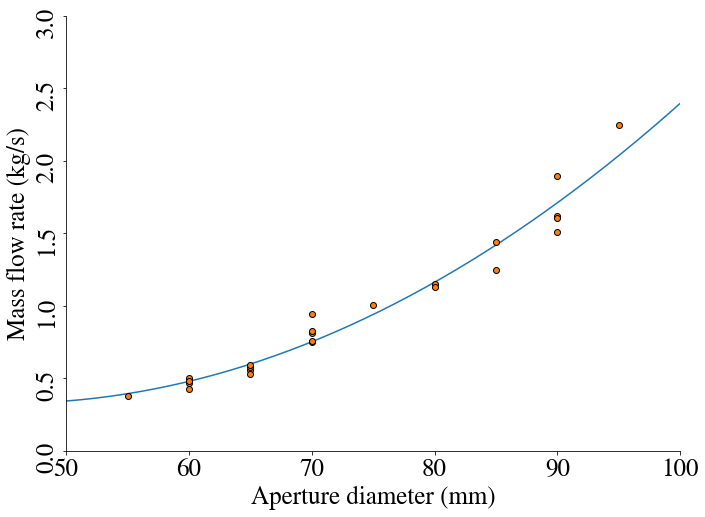

In [5]:
x = np.linspace(min(aperture_diameters)-10,max(aperture_diameters)+10)
y = flow_rate_function(x)
fontsize=25

fig, ax = geci_plot()
plt.plot(x,y)
plt.plot(aperture_diameters, flow_rates, 'o', markeredgecolor='k')
plt.xlabel("Aperture diameter (mm)", size=fontsize)
plt.ylabel("Mass flow rate (kg/s)", size=fontsize)
plt.xlim(50,100)
plt.ylim(0,3)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
plt.savefig('calibration.png', dpi=300, transparent=True)

## Swath width

In [6]:
density_profile = pd.read_csv("data/perfil.csv")

In [7]:
distance = density_profile.distancia.values
density_kg_per_ha = density_profile.densidad.values
density = density_kg_per_ha / 1e4 # To convert densities to kg per square meter
swath_width = nerd.calibration.get_swath_width(distance, density)

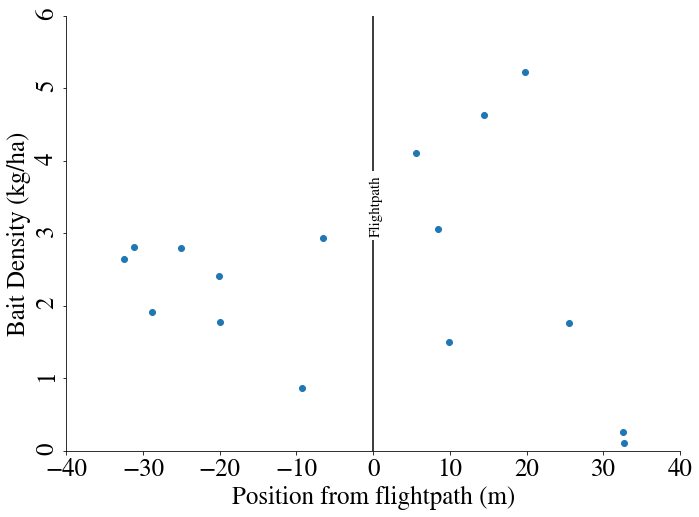

In [9]:
fig, ax = geci_plot()
plt.plot(distance, density_kg_per_ha, 'o')
plt.xlabel("Position from flightpath (m)", size=fontsize)
plt.ylabel("Bait Density (kg/ha)", size=fontsize)
plt.xlim(-40,40)
plt.ylim(0,6)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
plt.text(-0.5, 3, 'Flightpath', size=15, color='k', rotation=90,  bbox=dict(facecolor='w', edgecolor='none'))
plt.axvline(0, color="k")
#plt.axvline(swath_width/2, color="k")
plt.savefig('plots.png', dpi=300, transparent=True)

## Select best density function

In [60]:
aperture_diameter_data = 55 # milimetres
helicopter_speed_data = 20.5778 # meters per second (40 knots)

In [61]:
density_function = nerd.calibration.get_best_density_function(distance, density, aperture_diameter_data, helicopter_speed_data, swath_width, flow_rate_function)
estimated_profile = nerd.solver(aperture_diameter_data, helicopter_speed_data, swath_width, density_function, flow_rate_function)

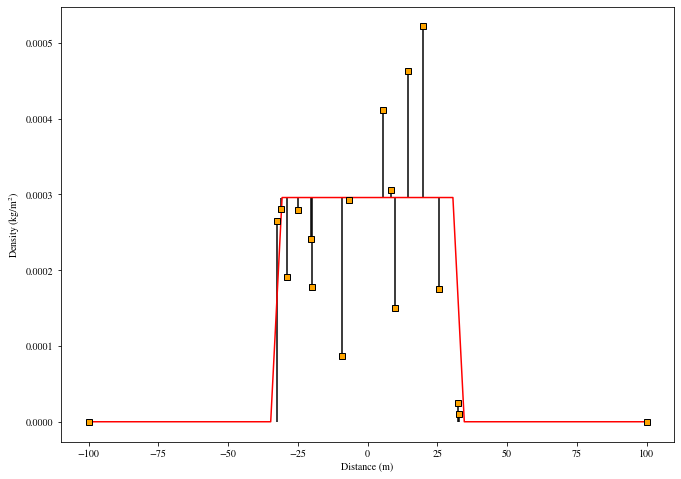

In [62]:
x = np.linspace(min(distance), max(distance))
y = estimated_profile(x)
estimated_density = estimated_profile(distance)
plt.figure(figsize=[11,8])
plt.plot(x, y, 'r', label="estimated density")
plt.vlines(distance, density, density + estimated_density - density, 'k')
plt.plot(distance, density, 's', color="orange", markeredgecolor="black", label="real density")
plt.xlabel("Distance (m)");
plt.ylabel("Density (kg/m$^2$)");

## Calibration model

In [132]:
aperture_diameters_domain = np.linspace(min(aperture_diameters),max(aperture_diameters))
helicopter_speeds_domain = np.linspace(10,50)
density_matrix = nerd.calibration.model(aperture_diameters_domain,helicopter_speeds_domain,swath_width,nerd.density_functions.uniform,flow_rate_function)
helicopter_speed_kmh=helicopter_speeds_domain*3.6

In [133]:
density_matrix[0]

array([0.00060909, 0.00062693, 0.00064619, 0.00066687, 0.00068896,
       0.00071247, 0.00073739, 0.00076374, 0.00079149, 0.00082066,
       0.00085125, 0.00088326, 0.00091668, 0.00095152, 0.00098777,
       0.00102544, 0.00106453, 0.00110503, 0.00114695, 0.00119028,
       0.00123503, 0.0012812 , 0.00132878, 0.00137778, 0.00142819,
       0.00148003, 0.00153327, 0.00158794, 0.00164402, 0.00170151,
       0.00176042, 0.00182075, 0.0018825 , 0.00194566, 0.00201023,
       0.00207623, 0.00214364, 0.00221246, 0.0022827 , 0.00235436,
       0.00242743, 0.00250192, 0.00257783, 0.00265515, 0.00273389,
       0.00281404, 0.00289562, 0.0029786 , 0.003063  , 0.00314882])

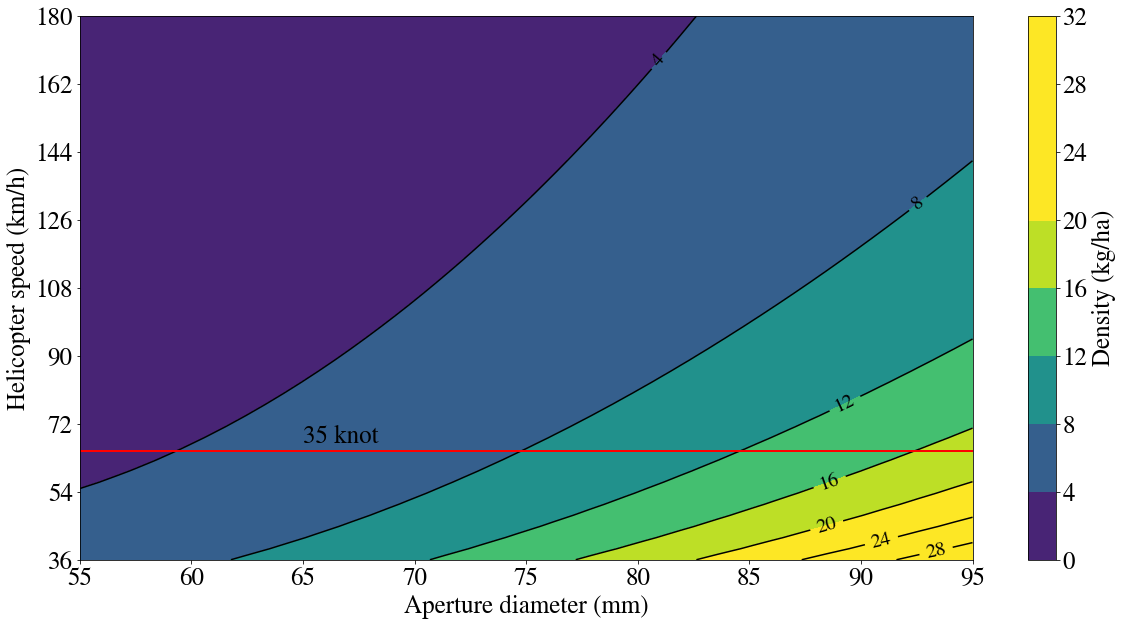

In [175]:
fig, ax = plt.subplots(figsize=(20,10))
color_contour = ax.contourf(aperture_diameters_domain, helicopter_speeds_domain, density_matrix*1e4, zorder=0, vmin=0, vmax=20)
line_contour = ax.contour(aperture_diameters_domain, helicopter_speeds_domain, density_matrix*1e4, levels=color_contour.levels, colors='k')
cbar = fig.colorbar(color_contour)
ax.clabel(line_contour, line_contour.levels, inline=True, fontsize=20, fmt='%1.0f')
plt.xlabel("Aperture diameter (mm)", size=fontsize)
plt.ylabel("Helicopter speed (km/h)", size=fontsize)
#plt.ylim(40/3.6, 150/3.6)
ytickslocs = ax.get_yticks()
y_ticks_kmh = ytickslocs*3.6
plt.yticks(ytickslocs, y_ticks_kmh.astype(int), size=fontsize)
plt.xticks(size=fontsize)
cbar.ax.set_ylabel("Density (kg/ha)", size=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
plt.axhline(18.0056, color='r', linewidth=2)
plt.text(65, 18.6, '35 knot', size=fontsize, color='k')
plt.savefig('contour_plot.png', dpi=300, transparent=True)